In [1]:
%matplotlib inline

# Import libraries
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Implementation of GPR
def get_kernel(sigma):
    def kernel(x0, x1):
        return np.exp(- sigma * (np.linalg.norm(x0 - x1) ** 2)) # Gaussian kernel
        #return (np.dot(x0,x1) + 1) ** sigma # Polynomial kernel
        #return np.dot(x0,x1) # Linear kernel
    return kernel

In [3]:
def gaussian_process_regression(train_x, train_y, kernel):
    N = len(train_x)
    k0 = np.zeros(shape=(N,N))
    beta = float(train_y.var())

    for n0, x0 in train_x.iterrows():
        for n1, x1 in train_x.iterrows():
            k0[n0,n1] = kernel(x0,x1)

    noise_matrix = np.eye(N) * beta
    a = np.linalg.inv(k0 + noise_matrix).dot(train_y)
    
    def prediction(x):
        y_new = 0
        for n in range(N):
            y_new += kernel(x, train_x.iloc[n]) * a[n]
        return y_new
    return prediction

In [5]:
#  Make datasets for training
n= 100
x = np.linspace(0, 2 * np.pi, n)
y = np.array([np.sin(i) for i in x])
y = y + 0.1 * np.random.randn(n)
train_x = pd.DataFrame({'x': x})
train_y = pd.DataFrame({'y': y})

# Perform GPR
prediction = gaussian_process_regression(train_x, train_y, get_kernel(50))

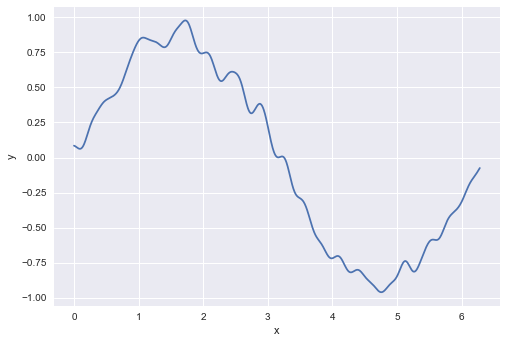

In [7]:
# Make a new dataset
n = 1000
test_x = np.linspace(0, 2 * np.pi, n)

# Prediction
test_y = [prediction(i) for i in test_x]
plt.plot(test_x, test_y)
plt.xlabel('x')
plt.ylabel('y')